# UCI Airfoil Self-Noise Data Set

**Data Set Information:**
   
   The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The
span of the airfoil and the observer position were the same in all of the experiments.

**Attribute Information:**

This problem has the following inputs:
    - Frequency, in Hertzs.
    - Angle of attack, in degrees.
    - Chord length, in meters.
    - Free-stream velocity, in meters per second.
    - Suction side displacement thickness, in meters.
The only output is:
    - Scaled sound pressure level, in decibels

Generic imports

In [45]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

IMPORT DATAS

In [109]:
! curl https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat -o ./airfoil_self_noise.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 59984  100 59984    0     0  45824      0  0:00:01  0:00:01 --:--:-- 45859


In [110]:
df = pd.read_csv('./airfoil_self_noise.dat',sep='\t',header=None)

In [111]:
col_names=['freq','angle','chord_l','velocity','suction','sound']
df.columns = col_names

FIRST LOOK AT DATAS

In [113]:
df.head()

,freq,angle,chord_l,velocity,suction,sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [43]:
df.describe()

,freq,angle,chord_l,velocity,suction,sound
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


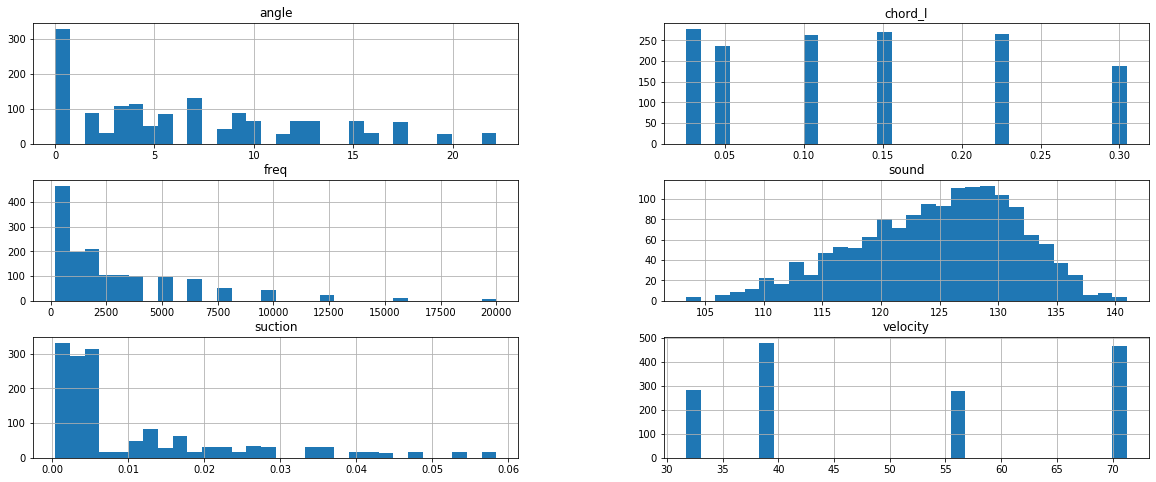

In [10]:
df.hist(bins=30,figsize=(20,8));

In [17]:
corr_matrix = df.corr()

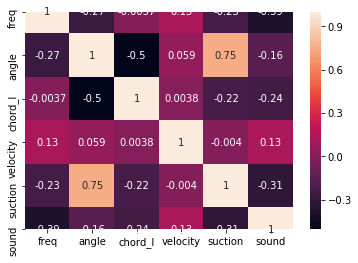

In [18]:
sns.heatmap(corr_matrix,annot=True);

In [19]:
corr_matrix["sound"].sort_values(ascending=False)

sound       1.000000
velocity    0.125103
angle      -0.156108
chord_l    -0.236162
suction    -0.312670
freq       -0.390711
Name: sound, dtype: float64

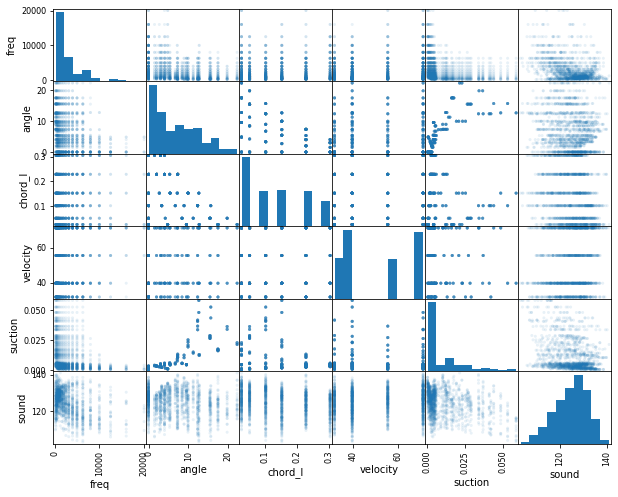

In [20]:
from pandas.plotting import scatter_matrix

scatter_matrix(df,figsize=(10,8),alpha=0.1);

CREATE TRAIN/TEST SETS

In [22]:
from sklearn.model_selection import train_test_split

X=df.drop(labels='sound', axis=1)
Y=df['sound']

# Create train and test sets
xtrain,xtest,ytrain,ytest= train_test_split(X,Y,test_size=0.2,random_state=37)

SCALE EXPLANATORY VARIABLES

In [23]:
from sklearn.preprocessing import StandardScaler

# Scale x data
scaler = StandardScaler()
scaler.fit(xtrain)

xtrain_s = scaler.transform(xtrain)
xtest_s = scaler.transform(xtest)

TRY DIFFERENT REGRESSOR FOR FIRST EVALUATION

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

regressor = [
            LinearRegression(),
            KNeighborsRegressor(),
            SVR(),
            DecisionTreeRegressor(random_state=37),
            RandomForestRegressor(random_state=37),
            AdaBoostRegressor(random_state=37),
           ]

reg_names=[
            'Linear', 
            'KNN',
            'SVR',
            'Decision Tree',
            'RandomForest',
            'AdaBoost',
            ]

# Apply different classifiers
bestscore=0
bestclf =''
for name, clf in zip(reg_names, regressor):
    reg = clf.fit(xtrain_s, ytrain)
    
    score1 = reg.score(xtest_s, ytest)*100
    print("%s Score : %.2f %%" % (name, score1))
    if score1 > bestscore:
        bestscore = score1
        ypred = reg.predict(xtest_s)
        bestclf = name

Linear Score : 52.15 %
KNN Score : 79.72 %
SVR Score : 69.56 %
Decision Tree Score : 87.37 %
RandomForest Score : 94.50 %
AdaBoost Score : 67.69 %


In [28]:
print('Best score using: %s' % bestclf)

Best score using: RandomForest


CHECK ERROR OF BEST REGRESSOR

In [47]:
from sklearn.metrics import mean_squared_error

best_reg_mse = mean_squared_error(ytest,ypred)
best_reg_rmse = np.sqrt(best_reg_mse)

best_reg_rmse

1.656927888823407

CROSS VALIDATION EVALUATION

In [88]:
from sklearn.model_selection import cross_val_score

reg = RandomForestRegressor(random_state=37)
model = reg.fit(xtrain_s, ytrain)

cross_mse = cross_val_score(model,xtrain_s, ytrain,scoring='neg_mean_squared_error',cv=10)
cross_rmse = np.sqrt(-cross_mse)                            

print("MSE scores:",cross_rmse)
print("avg:",cross_rmse.mean())
print("std dev:",cross_rmse.std())

MSE scores: [2.04318486 1.65888434 1.94169341 1.89796937 1.33899868 1.9952975
 1.78845905 1.56683083 1.47136038 2.01847508]
avg: 1.7721153502684506
std dev: 0.2370341183593365


TRY MODEL IMPROVEMENT BY TUNING PARAMETERS USING GRID SEARCH

In [99]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'bootstrap':[True,False],
        'n_estimators':[5,10,50,100,],
        'max_features':[2,3,4,5,'auto'],
        'max_depth':[2,5,10,None],
    }
]

reg = RandomForestRegressor(random_state=37)
grid_search = GridSearchCV(reg,param_grid,cv=10,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(xtrain_s,ytrain);


In [100]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': None, 'max_features': 4, 'n_estimators': 100}

In [101]:
best_grid_mse = grid_search.best_score_
best_grid_rmse = np.sqrt(-grid_search.best_score_)
best_grid_rmse

1.7709366512624893

EVALUATE MODEL ON TEST DATASET

In [108]:
ypred = grid_search.best_estimator_.predict(xtest_s)

score = grid_search.best_estimator_.score(xtest_s, ytest)*100

mse = mean_squared_error(ytest,ypred)
rmse = np.sqrt(mse)

print("Model score: %.2f%% giving an error of %.2f dB on test dataset (%d obs)" % (score,rmse,len(ytest)))


Model score: 94.66% giving an error of 1.63 dB on test dataset (301 obs)
